In [58]:
import sys
sys.path.append("../../XLEMOO")

In [59]:
from XLEMOO.LEMOO import EAParams, MLParams, LEMParams, LEMOO, PastGeneration
from XLEMOO.fitness_indicators import asf_wrapper
from XLEMOO.selection import SelectNBest
from XLEMOO.plotting import show_rules
from XLEMOO.ruleset_interpreter import extract_skoped_rules
from desdeo_emo.recombination import SBX_xover, BP_mutation
from desdeo_tools.scalarization.ASF import PointMethodASF
from desdeo_problem.testproblems import vehicle_crashworthiness

import matplotlib.pyplot as plt
import numpy as np
from imodels import SkopeRulesClassifier

## Initialize the problem

In [60]:
n_objectives = 3
n_variables = 5

problem = vehicle_crashworthiness()

## Initialize an XLEMOO method

In [75]:
ideal = np.array([1600.0, 6.0, 0.038])
nadir = np.array([1700.0, 12.0, 0.2])
ref_point = np.array([1600.0, 8.0, 0.07])  # the reference point
# ref_point = np.array([1690.0, 6.5, 0.039])  # the reference point

# define the achievement scalarizing function as the fitness function
ref_asf = asf_wrapper(PointMethodASF(ideal=ideal, nadir=nadir), {"reference_point": ref_point})
fitness_fun = ref_asf

lem_params = LEMParams(
    use_darwin=True,
    use_ml=True,
    fitness_indicator=fitness_fun,
    ml_probe = 1,
    ml_threshold = None,
    darwin_probe = None,
    darwin_threshold = None,
    total_iterations=10,
)

ea_params = EAParams(
    population_size=50,
    cross_over_op=SBX_xover(),
    mutation_op=BP_mutation(problem.get_variable_lower_bounds(), problem.get_variable_upper_bounds()),
    selection_op=SelectNBest(None, 50),  # keep population size constant
    population_init_design="LHSDesign",
    iterations_per_cycle=19,
)

ml = SkopeRulesClassifier(precision_min=0.1, n_estimators=30, max_features=None, max_depth=None, bootstrap=True, bootstrap_features=True, random_state=1)
ml_params = MLParams(
    H_split=0.20,
    L_split=0.20,
    ml_model=ml,
    instantation_factor=10,
    generation_lookback=0,
    ancestral_recall=0,
    unique_only=True,
    iterations_per_cycle=1,
)

lemoo = LEMOO(problem, lem_params, ea_params, ml_params)

## Run the XLEMOO method

In [76]:
lemoo.run_iterations()

{'darwin_mode': 190, 'learning_mode': 10, 'total_iterations': 10}

## Extract most accurate rules

In [77]:
rules, accuracies = extract_skoped_rules(lemoo.current_ml_model)
problem_lower_bounds = problem.get_variable_lower_bounds()
problem_upper_bounds = problem.get_variable_upper_bounds()

rules_for_vars = {f"X_{i}": {">": [problem_lower_bounds[i], -1], "<=": [problem_upper_bounds[i], -1]} for i in range(n_variables)}

for accuracy, rule in zip(accuracies, rules):
    for key in rule:
        var_name = key[0]
        op = key[1]
        
        # check accuracy
        if rules_for_vars[var_name][op][1] < accuracy: 
            # update accuracy
            rules_for_vars[var_name][op][1] = accuracy
            if op == "<=":
                # tighten rule, if necessary
                if float(rule[(var_name, op)]) <= rules_for_vars[var_name][op][0]:
                    rules_for_vars[var_name][op][0] = float(rule[(var_name, op)])
            elif op == ">":
                # tighten rule, if necessary
                if float(rule[(var_name, op)]) > rules_for_vars[var_name][op][0]:
                    rules_for_vars[var_name][op][0] = float(rule[(var_name, op)])

## Extract bounds of the final population and complete missing rules

In [94]:
lower_bounds = np.min(lemoo._generation_history[-1].individuals, axis=0)
upper_bounds = np.max(lemoo._generation_history[-1].individuals, axis=0)

# if there are no upper or lower bound for some vars in the rules, use the min or max from the population
for var_i, var_name in enumerate(rules_for_vars):
    for op in rules_for_vars[var_name]:
        if op == "<=":
            if rules_for_vars[var_name][op][1] == -1:
                # replace missing rule with bound from population
                rules_for_vars[var_name][op][0] = upper_bounds[var_i]
        if op == ">":
            if rules_for_vars[var_name][op][1] == -1:
                rules_for_vars[var_name][op][0] = lower_bounds[var_i]

print("RULES:")
print("Var\tLower(R)\t\tUpper(R)\t\tLower(P)\t\tUpper(P)")
for i, rule in enumerate(rules_for_vars):
    msg = (f"{rule}\t{np.round(rules_for_vars[rule]['>'][0], 5)}\t({np.round(rules_for_vars[rule]['>'][1], 3)})\t\t{np.round(rules_for_vars[rule]['<='][0], 5)} ({np.round(rules_for_vars[rule]['<='][1], 3)})\t\t"
           f"{np.round(lower_bounds[i], 5)}\t\t\t{np.round(upper_bounds[i], 5)}")
    msg_tex = (f"${rule}$ & ${np.round(rules_for_vars[rule]['>'][0], 5)}$ & $({np.round(rules_for_vars[rule]['>'][1], 3)})$ & ${np.round(rules_for_vars[rule]['<='][0], 5)}$ & $({np.round(rules_for_vars[rule]['<='][1], 3)})$ &"
           f"${np.round(lower_bounds[i], 5)}$ & ${np.round(upper_bounds[i], 5)}$ \\\\")
    # print(msg)
    print(msg_tex)

RULES:
Var	Lower(R)		Upper(R)		Lower(P)		Upper(P)
$X_0$ & $1.0$ & $(0.518)$ & $1.00513$ & $(1.0)$ &$1.0$ & $1.0$ \\
$X_1$ & $1.0$ & $(0.478)$ & $1.0$ & $(1.0)$ &$1.0$ & $1.0$ \\
$X_2$ & $1.0$ & $(0.404)$ & $1.00004$ & $(1.0)$ &$1.0$ & $1.0$ \\
$X_3$ & $1.0$ & $(-1)$ & $1.00428$ & $(1.0)$ &$1.0$ & $1.0$ \\
$X_4$ & $1.0$ & $(0.232)$ & $1.0$ & $(1.0)$ &$1.0$ & $1.0$ \\


## Generate new solutions based on the data to help validate the rules

In [79]:
sample_rules = np.random.uniform(low=[rules_for_vars[f"X_{i}"]['>'][0] for i in range(n_variables)], high=[rules_for_vars[f"X_{i}"]['<='][0] for i in range(n_variables)], size=(100000, n_variables))
fitness_values_rules = fitness_fun(problem.evaluate(sample_rules).objectives)

## Plot the fitnesses of generated solutions

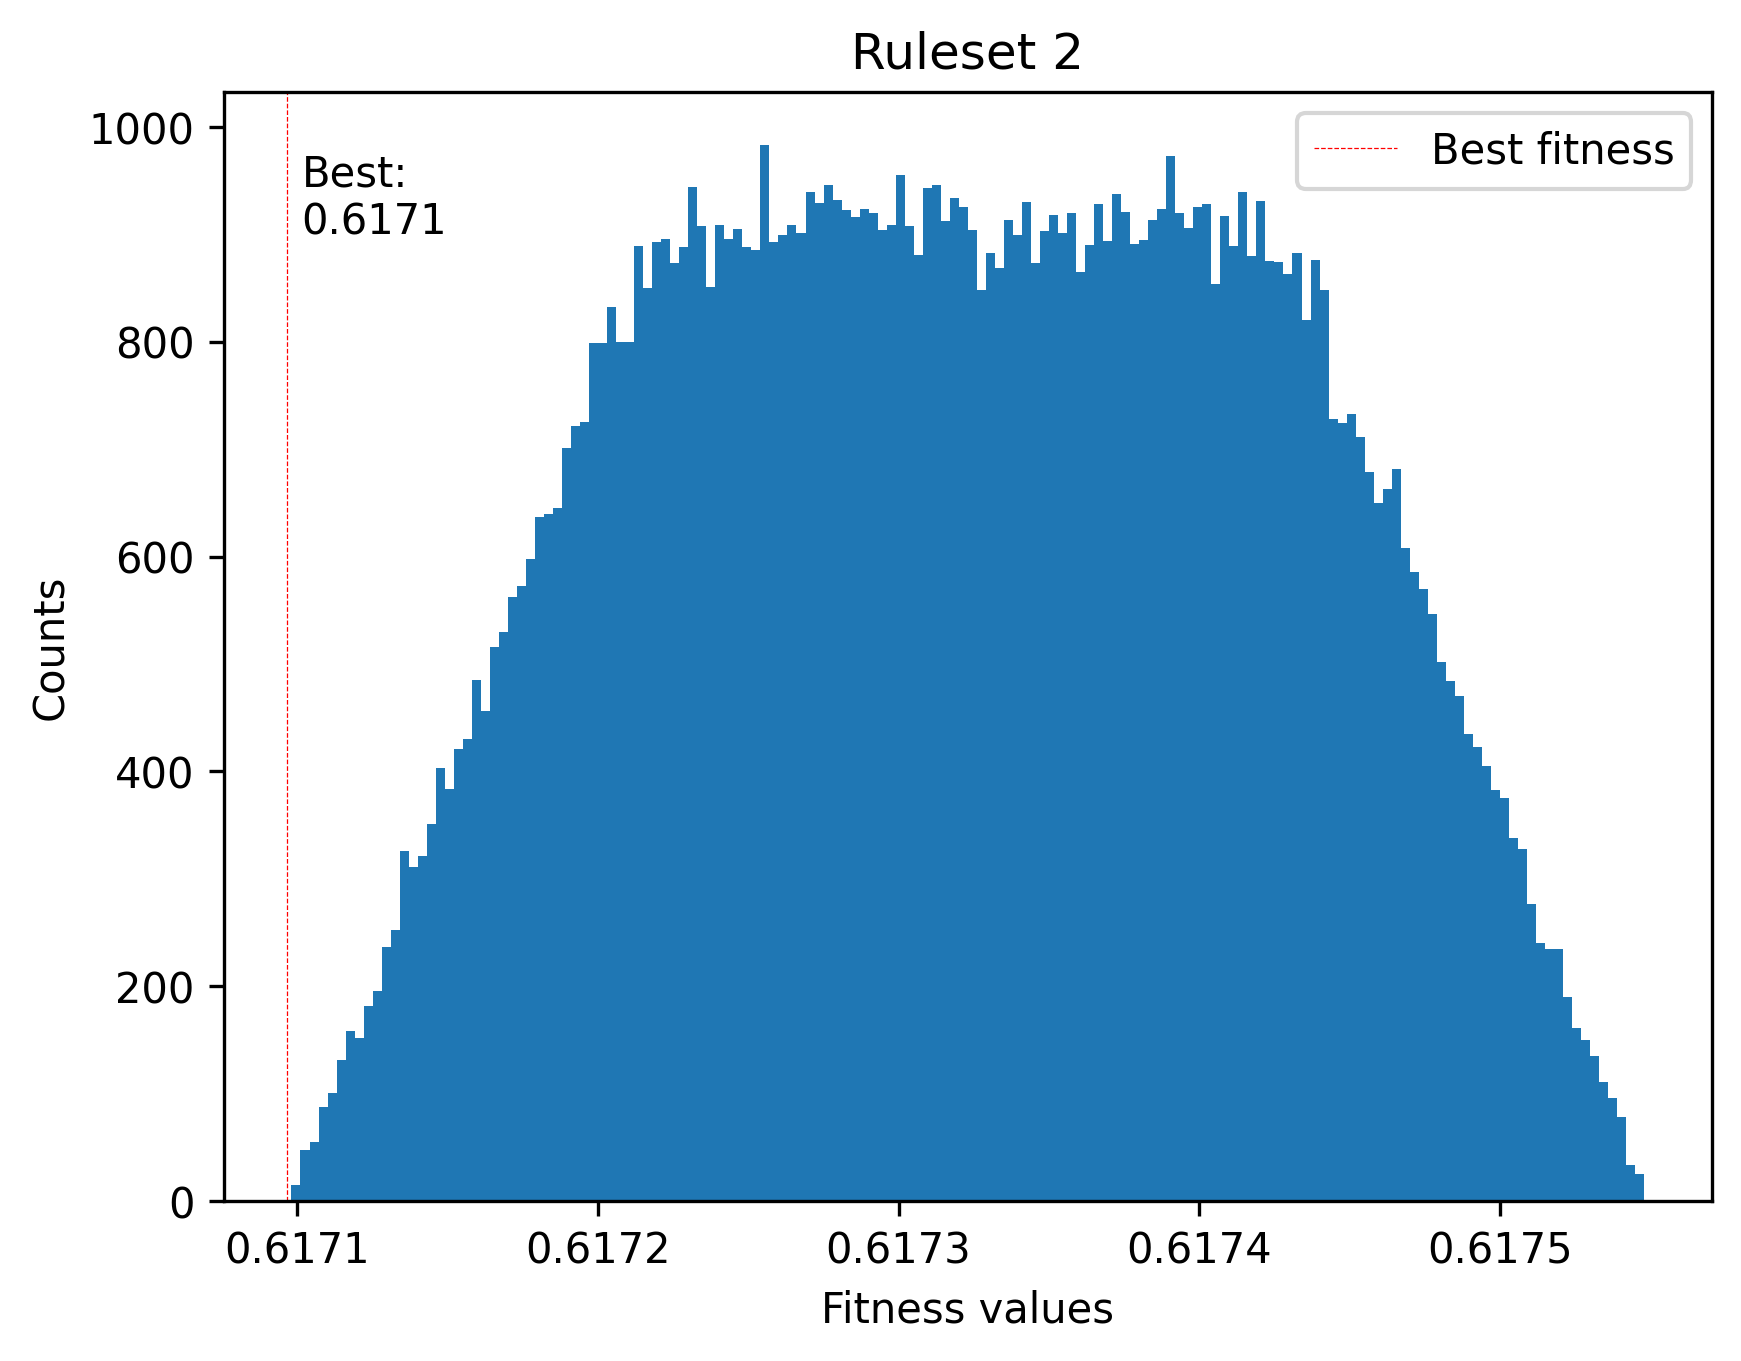

In [93]:
best_fitness = lemoo._generation_history[-1].fitness_fun_values[0]

fig = plt.figure()
plt.hist(fitness_values_rules, bins=150)
plt.xlabel("Fitness values")
plt.ylabel("Counts")
plt.axvline(best_fitness, c="red", linestyle="dashed", linewidth=0.3, label="Best fitness")
plt.text(best_fitness + 0.000005, 900, f"Best:\n{best_fitness[0].round(5)}")
plt.title("Ruleset 2")
plt.legend()
# fig.savefig("/home/kilo/workspace/XLEMOO/figures/rules_hist_2.pdf")